In [1]:
#include <vtkm_config_cling.h>
#include <lodepng_config_cling.h>
#include <iostream>
#include <limits>
#include <vector>
#include <tuple>
#include <JSONPNGConvert.h>
#include <lodepng.h>
#include <vtkm/cont/ArrayHandleConstant.h>
#include <vtkm/rendering/CanvasRayTracer.h>
#include <vtkm/rendering/raytracing/Camera.h>
#include <vtkm/cont/internal/DeviceAdapterAlgorithmGeneral.h>
#include <vtkm/cont/ArrayHandle.h>
#include <vtkm/cont/ArrayHandleCompositeVector.h>
#include <vtkm/rendering/raytracing/Ray.h>
#include <vtkm/rendering/raytracing/RayOperations.h>
#include <omp.h>
#include <vtkm/cont/Algorithm.h>
#include <vtkm/worklet/Invoker.h>
#include <fstream>
#include "Worklets.h"
#include "SurfaceWorklets.h"
#include "EmitWorklet.h"
#include "ScatterWorklet.h"
#include "PdfWorklet.h"

#include "CornellBox.h"
#include "PathAlgorithms.h"

using ArrayType = vtkm::cont::ArrayHandle<vec3>;
using RayType = vtkm::rendering::raytracing::Ray<float>;
std::unique_ptr<CornellBox> cb = std::make_unique<CornellBox>();
std::unique_ptr<vtkm::cont::ArrayHandle<vec3>> cols = std::make_unique<vtkm::cont::ArrayHandle<vec3>>();

constexpr int nx = 128, ny = 128;

In [2]:
template<typename HitRecord,
         typename HitId>
void intersect(RayType &rays,
               HitRecord &hrecs,
               HitId &hids,
               vtkm::cont::ArrayHandle<float> &tmin,
               ArrayType &emitted,
               ArrayType &attenuation,
               const vtkm::Id depth)
{
  using MyAlgos = details::PathAlgorithms<vtkm::cont::DeviceAdapterAlgorithm<VTKM_DEFAULT_DEVICE_ADAPTER_TAG>, VTKM_DEFAULT_DEVICE_ADAPTER_TAG>;
  using StorageTag = vtkm::cont::StorageTagBasic;

  MyAlgos::Copy<float, float, StorageTag>(std::numeric_limits<float>::max(), rays.Distance);
  MyAlgos::Copy<float, float, StorageTag>(0.001, tmin);
  vtkm::worklet::Invoker Invoke;

  vtkm::Id canvasSize = rays.DirX.GetNumberOfValues();
  for (int i=0; i<cb->cellTypeArray.size(); i++){
    if (cb->cellTypeArray[i] == 0){
      YZRectWorklet yz(canvasSize, depth);

      Invoke(yz, rays.Origin, rays.Dir, hrecs, hids, tmin, rays.Distance, rays.Status, cb->pts1[i], cb->pts2[i],
                    cb->matIdx[i], cb->texIdx[i],cb->translateOffset[i], cb->angleArray[i],cb->flipped[i]);
    }
    else if (cb->cellTypeArray[i] == 1){
      XZRectExecWrapper surf;
      XZRectWorklet xz(canvasSize, depth);
      Invoke(xz, rays.Origin, rays.Dir, hrecs, hids, tmin, rays.Distance, rays.Status, surf, cb->pts1[i], cb->pts2[i],
                  cb->matIdx[i], cb->texIdx[i],cb->translateOffset[i], cb->angleArray[i],cb->flipped[i]);


    }
    else if (cb->cellTypeArray[i] == 2){
      //xy
      XYRectWorklet xy(canvasSize, depth);
      Invoke(xy, rays.Origin, rays.Dir, hrecs, hids, tmin, rays.Distance, rays.Status, cb->pts1[i], cb->pts2[i],
                  cb->matIdx[i], cb->texIdx[i],cb->translateOffset[i], cb->angleArray[i],cb->flipped[i]);

    }
    else if (cb->cellTypeArray[i] == 3){
      SphereExecWrapper surf;
      SphereIntersecttWorklet sphereIntersect(canvasSize, depth);
      Invoke(sphereIntersect, rays.Origin, rays.Dir, hrecs,hids, tmin, rays.Distance, rays.Status, surf, cb->pts1[i], cb->pts2[i],
                  cb->matIdx[i], cb->texIdx[i]);

    }
  }


  CollectIntersecttWorklet collectIntersect(canvasSize, depth);
  Invoke(collectIntersect, rays.Status, emitted, attenuation);

}


In [3]:
template<typename HitRecord, typename HitId>
void applyMaterials(RayType &rays,
                    HitRecord &hrecs,
                    HitId &hids,
                    vtkm::cont::ArrayHandle<ScatterRecord> &srecs,
                    vtkm::cont::ArrayHandle<vec3> tex,
                    vtkm::cont::ArrayHandle<int> matType,
                    vtkm::cont::ArrayHandle<int> texType,
                    ArrayType &emitted,
                    vtkm::cont::ArrayHandle<unsigned int> &seeds,
                    vtkm::Id canvasSize,
                    vtkm::Id depth)
{
  LambertianWorklet lmbWorklet( canvasSize, depth);
  DiffuseLightWorklet dlWorklet(canvasSize ,depth);
  DielectricWorklet deWorklet( canvasSize ,depth, 1.5, canvasSize);

  vtkm::worklet::Invoker Invoke;
  Invoke(lmbWorklet, rays.Origin, rays.Dir, hrecs, hids, srecs, rays.Status,
              tex, matType, texType, emitted);

  Invoke(dlWorklet, rays.Origin, rays.Dir, hrecs, hids, srecs, rays.Status,
              tex, matType, texType, emitted);

  Invoke(deWorklet, seeds, rays.Origin, rays.Dir, hrecs, hids, srecs, rays.Status,
                tex, matType, texType, emitted);

}

In [4]:
template<typename HitRecord>
void generateRays(
    vtkm::cont::ArrayHandle<int> &whichPDF,
    HitRecord &hrecs,
    ArrayType &generated_dir,
    vtkm::cont::ArrayHandle<unsigned int> &seeds,
    std::vector<ArrayType> &light_box_pts,
    std::vector<ArrayType> &light_sphere_pts
    )
{
  vtkm::worklet::Invoker Invoke;
  GenerateDir genDir(3);
  CosineGenerateDir cosGenDir(1);
  XZRectGenerateDir xzRectGenDir(2);
  SphereGenerateDir sphereGenDir(3);

  Invoke(genDir, seeds, whichPDF);
  Invoke(cosGenDir, whichPDF, hrecs, generated_dir, seeds,  light_sphere_pts[0], light_sphere_pts[1]);
  Invoke(xzRectGenDir, whichPDF, hrecs, generated_dir, seeds, light_box_pts[0], light_box_pts[1]);
  Invoke(sphereGenDir, whichPDF, hrecs, generated_dir, seeds, light_sphere_pts[0], light_sphere_pts[1]);
  }

In [5]:
template<typename HitRecord>
void applyPDFs(
    RayType &rays,
    HitRecord &hrecs,
    vtkm::cont::ArrayHandle<ScatterRecord> srecs,
    vtkm::cont::ArrayHandle<vtkm::Float32> &sum_values,
    ArrayType generated_dir,
    ArrayType &attenuation,
    vtkm::cont::ArrayHandle<unsigned int> &seeds,
    std::vector<ArrayType> light_box_pts,
    std::vector<ArrayType> light_sphere_pts,
    int lightables,
    vtkm::Id canvasSize,
    vtkm::Id depth
    )
{
  vtkm::worklet::Invoker Invoke;
  XZRectPDFWorklet xzPDFWorklet(lightables);
  SpherePDFWorklet spherePDFWorklet(lightables);
  PDFCosineWorklet pdfWorklet(canvasSize, depth, canvasSize, lightables);
  XZRectExecWrapper xzsurf;
  Invoke(xzPDFWorklet, rays.Origin, rays.Dir,hrecs, rays.Status, sum_values, generated_dir, seeds,xzsurf, light_box_pts[0], light_box_pts[1]);
  SphereExecWrapper surf;

  Invoke(spherePDFWorklet, rays.Origin, rays.Dir,hrecs, rays.Status, sum_values, generated_dir, seeds, surf, light_sphere_pts[0], light_sphere_pts[1]);

  Invoke(pdfWorklet, rays.Origin, rays.Dir, hrecs, srecs, rays.Status, sum_values, generated_dir,  rays.Origin, rays.Dir, attenuation);

}

In [6]:
template <typename T, typename U, class CIn, class COut, class BinaryFunctor>
VTKM_CONT static T MyScanInclusive(const vtkm::cont::ArrayHandle<T, CIn>& input,
                                 vtkm::cont::ArrayHandle<U, COut>& output)
{
  vtkm::cont::detail::ScanInclusiveResultFunctor<U> functor;
  vtkm::cont::TryExecute(functor, input, output);
  return functor.result;
}

In [7]:
using MyAlgos = details::PathAlgorithms<vtkm::cont::DeviceAdapterAlgorithm<VTKM_DEFAULT_DEVICE_ADAPTER_TAG>, VTKM_DEFAULT_DEVICE_ADAPTER_TAG>;
using StorageTag = vtkm::cont::StorageTagBasic;
using Device = VTKM_DEFAULT_DEVICE_ADAPTER_TAG;
[&](){
auto try_and_err = [&](){

  const int ns = 1;
  const int depthcount = 2;

  auto canvasSize = nx*ny;

  constexpr int lightables = 2;
  std::vector<ArrayType> light_box_pts(2), light_sphere_pts(2);
  light_box_pts[0].Allocate(1);
  light_box_pts[0].GetPortalControl().Set(0, vec3(213, 554, 227));
  light_box_pts[1].Allocate(1);
  light_box_pts[1].GetPortalControl().Set(0, vec3(343, 554, 332));

  light_sphere_pts[0].Allocate(1);
  light_sphere_pts[0].GetPortalControl().Set(0, vec3(190, 90, 190));
  light_sphere_pts[1].Allocate(1);
  light_sphere_pts[1].GetPortalControl().Set(0, vec3(90,0,0));

  cb->build();

  vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32, 2>> uvs;
  uvs.Allocate(nx*ny);

  vtkm::cont::ArrayHandle<vtkm::Id> rays_index;

  vtkm::cont::ArrayHandle<unsigned int> seeds;
  seeds.Allocate(canvasSize);
  vtkm::rendering::raytracing::Ray<float> rays;
  rays.EnableIntersectionData();
  vtkm::rendering::raytracing::RayOperations::Resize(rays, canvasSize, Device());


  MyAlgos::Copy<vtkm::UInt8, vtkm::UInt8, StorageTag>((1UL << 3), rays.Status);

  vtkm::cont::ArrayHandleConstant<vec3> zero(vec3(0.0f), nx*ny);
  cols->Allocate(nx*ny);
  MyAlgos::Copy<vec3, vec3, StorageTag>(vec3(0.0f), *cols.get());

  vtkm::cont::ArrayHandle<vtkm::Float32> sum_values;

  vtkm::cont::ArrayHandle<ScatterRecord> srecs;

  vtkm::cont::ArrayHandle<vtkm::Int32> matIdArray, texIdArray;
  matIdArray.Allocate(canvasSize);
  texIdArray.Allocate(canvasSize);

  vtkm::cont::ArrayHandle<vtkm::Float32> pxArray,pyArray,pzArray;
  pxArray.Allocate(rays.U.GetNumberOfValues());
  pyArray.Allocate(rays.U.GetNumberOfValues());
  pzArray.Allocate(rays.U.GetNumberOfValues());

  using HitRecord = vtkm::cont::ArrayHandleCompositeVector<decltype(rays.U),
  decltype(rays.V),
  decltype(rays.Distance),
  decltype(rays.NormalX),
  decltype(rays.NormalY),
  decltype(rays.NormalZ),
  decltype(pxArray),
  decltype(pyArray),
  decltype(pzArray)>;

  auto hrecs = HitRecord(rays.U, rays.V, rays.Distance, rays.NormalX, rays.NormalY, rays.NormalZ, pxArray, pyArray, pzArray);

  using HitId = vtkm::cont::ArrayHandleCompositeVector<decltype(matIdArray), decltype(texIdArray)>;
  auto hids = HitId(matIdArray, texIdArray);

  vtkm::cont::ArrayHandle<float> tmin;
  ArrayType attenuation;
  ArrayType emitted;
  ArrayType generated_dir;
  vtkm::cont::ArrayHandle<int> whichPDF;

  attenuation.Allocate(canvasSize* depthcount);
  emitted.Allocate(canvasSize * depthcount);
  srecs.Allocate(canvasSize);
  ArrayType sumtotl;
  sumtotl.Allocate(canvasSize);
  tmin.Allocate(canvasSize);
  sum_values.Allocate(nx*ny);
  generated_dir.Allocate(nx*ny);
  whichPDF.Allocate(nx*ny);

  for (unsigned int i=0; i<canvasSize; i++){

    unsigned int idx = i;
    auto val = xorshiftWang::getWang32(idx);
    idx++;
    val = xorshiftWang::getWang32(val);
    idx++;
    val = xorshiftWang::getWang32(val);
    idx++;
    val = xorshiftWang::getWang32(val);
    seeds.GetPortalControl().Set(i, val);
  }

  vtkm::worklet::Invoker Invoke;
  for (int s =0; s<ns; s++){
    UVGen uvgen(nx, ny, s);

    Invoke(uvgen, seeds, uvs);
    RayGen raygen(nx,ny, 40,40,
                  vtkm::Vec<vtkm::Float32,3>(0,0,1),
                  vtkm::Vec<vtkm::Float32,3>(0,1,0),
                  0, nx, 0, 0, ns);
    Invoke(raygen, rays.DirX, rays.DirY, rays.DirZ, seeds, rays.PixelIdx);

    vec3 lookfrom(278, 278, -800);

    MyAlgos::Copy<float, float, StorageTag>(lookfrom[0], rays.OriginX);
    MyAlgos::Copy<float, float, StorageTag>(lookfrom[1], rays.OriginY);
    MyAlgos::Copy<float, float, StorageTag>(lookfrom[2], rays.OriginZ);


    MyAlgos::Copy<vtkm::UInt8, vtkm::UInt8, StorageTag>((1UL << 3), rays.Status);


    for (int depth=0; depth<depthcount; depth++){
      MyAlgos::Copy<float, float, StorageTag>(0, sum_values);


      intersect(rays, hrecs,hids, tmin, emitted, attenuation, depth);

      applyMaterials(rays, hrecs, hids, srecs, cb->tex, cb->matType, cb->texType, emitted, seeds, canvasSize, depth);
      generateRays(whichPDF, hrecs, generated_dir, seeds, light_box_pts, light_sphere_pts);
      applyPDFs(rays, hrecs, srecs, sum_values, generated_dir, attenuation, seeds, light_box_pts, light_sphere_pts, lightables, canvasSize, depth);

      vtkm::cont::ArrayHandleCast<vtkm::Int32, vtkm::cont::ArrayHandle<vtkm::UInt8>> castedStatus(rays.Status);

      std::cout << "fin: " << depth << " " << static_cast<int>(vtkm::cont::Algorithm::Reduce(castedStatus, vtkm::Int32(0))) << std::endl;
    }

    using CountType = vtkm::cont::ArrayHandleCounting<vtkm::Id>;


    MyAlgos::SliceTransform<
        decltype(emitted),
        decltype(zero),
        decltype(sumtotl),
        decltype(vtkm::Sum())>
        (std::make_tuple((depthcount-1)*canvasSize, (depthcount-1)*canvasSize + canvasSize), emitted,
         std::make_tuple(0, canvasSize), zero,
         std::make_tuple(0, canvasSize), sumtotl, vtkm::Sum());

    for (int depth = depthcount-2; depth >=0; depth--){
      MyAlgos::SliceTransform<
          decltype(attenuation),
          decltype(sumtotl),
          decltype(sumtotl),
          decltype(vtkm::Multiply())>
          (std::make_tuple(depth*canvasSize, depth*canvasSize + canvasSize), attenuation,
           std::make_tuple(0, canvasSize), sumtotl,
           std::make_tuple(0, canvasSize), sumtotl, vtkm::Multiply());

      MyAlgos::SliceTransform<
          decltype(emitted),
          decltype(sumtotl),
          decltype(sumtotl),
          decltype(vtkm::Sum())>
          (std::make_tuple(depth*canvasSize, depth*canvasSize + canvasSize), emitted,
           std::make_tuple(0, canvasSize), sumtotl,
           std::make_tuple(0, canvasSize), sumtotl, vtkm::Sum());


    }

    vtkm::cont::Algorithm::Transform(*cols.get(), sumtotl, *cols.get(), vtkm::Sum());

    std::cout << "ns: " << s <<" " << vtkm::cont::Algorithm::Reduce(sumtotl, vec3(0.0)) << std::endl;

  }

  std::vector<std::uint8_t> ImageBuffer;
  ImageBuffer.reserve(nx*ny*4);

  for (int i=0; i<cols->GetNumberOfValues(); i++){
    auto col = cols->GetPortalConstControl().Get(i);
    col = col / float(ns);
    col = vec3( sqrt(col[0]), sqrt(col[1]), sqrt(col[2]) );
  }
};
try_and_err();
}();

fin: 0 123795
fin: 1 91543
ns: 0 [-nan,-nan,-nan]


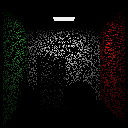

In [9]:
#include <xcpp/xdisplay.hpp>
#include <VTKmXeusRender.h>
#include <VTKmXeusConvertPng.h>
std::unique_ptr<VTKmXeusRender> renderer;

[&](){
auto try_and_err = [&]() {
renderer = std::make_unique<VTKmXeusRender>();
renderer->Display(*cols.get(), nx, ny);
};
    try_and_err();
}();
